In [1]:
# Cell 1: Imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

print("✅ Imports OK")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✅ Imports OK
PyTorch: 2.8.0+cu129
CUDA: True


In [2]:
# Cell 2: Load normalization stats
with open('data/metadata/normalization_stats.json') as f:
    stats = json.load(f)

mean = stats['mean']
std = stats['std']

print(f"\nMean: {mean}")
print(f"Std:  {std}")


Mean: [0.4908561706542969, 0.49303561449050903, 0.4940687119960785]
Std:  [0.2407049834728241, 0.24082882702350616, 0.24142147600650787]


In [3]:
# Cell 3: Define transforms
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("\n✅ Transforms defined")
print("  Train: Resize + Augmentation + Normalize")
print("  Test:  Resize + Normalize only")


✅ Transforms defined
  Train: Resize + Augmentation + Normalize
  Test:  Resize + Normalize only


In [4]:
# Cell 4: Create datasets
train_dataset = datasets.ImageFolder('data/processed/train', transform=train_transform)
val_dataset = datasets.ImageFolder('data/processed/val', transform=test_transform)
test_dataset = datasets.ImageFolder('data/processed/test', transform=test_transform)

print(f"\n✅ Datasets:")
print(f"  Train: {len(train_dataset):,}")
print(f"  Val:   {len(val_dataset):,}")
print(f"  Test:  {len(test_dataset):,}")
print(f"\n  Classes: {train_dataset.classes}")
print(f"  Mapping: {train_dataset.class_to_idx}")


✅ Datasets:
  Train: 11,546
  Val:   2,471
  Test:  2,471

  Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
  Mapping: {'COVID-19': 0, 'Normal': 1, 'Pneumonia': 2, 'Tuberculosis': 3}


In [5]:
# Cell 5: Create dataloaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

print(f"\n✅ DataLoaders (batch_size={batch_size}):")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val:   {len(val_loader)} batches")
print(f"  Test:  {len(test_loader)} batches")


✅ DataLoaders (batch_size=16):
  Train: 722 batches
  Val:   155 batches
  Test:  155 batches


In [6]:
# Cell 6: Test loading
images, labels = next(iter(train_loader))

print("\n" + "=" * 70)
print("✅ BATCH VERIFICATION")
print("=" * 70)
print(f"Batch shape:  {images.shape}")
print(f"Expected:     torch.Size([{batch_size}, 3, 512, 512])")
print(f"Labels:       {labels[:8]}")
print(f"\nStats (normalized):")
print(f"  Min:  {images.min():.4f}")
print(f"  Max:  {images.max():.4f}")
print(f"  Mean: {images.mean():.4f} (should be ~0)")
print(f"  Std:  {images.std():.4f} (should be ~1)")

if abs(images.mean()) < 0.1 and abs(images.std()-1) < 0.2:
    print("\n✅ Normalization working correctly!")


✅ BATCH VERIFICATION
Batch shape:  torch.Size([16, 3, 512, 512])
Expected:     torch.Size([16, 3, 512, 512])
Labels:       tensor([1, 2, 1, 1, 2, 2, 2, 2])

Stats (normalized):
  Min:  -2.0472
  Max:  2.1152
  Mean: 0.0212 (should be ~0)
  Std:  0.9942 (should be ~1)

✅ Normalization working correctly!



🖼️  Visualizing training batch:


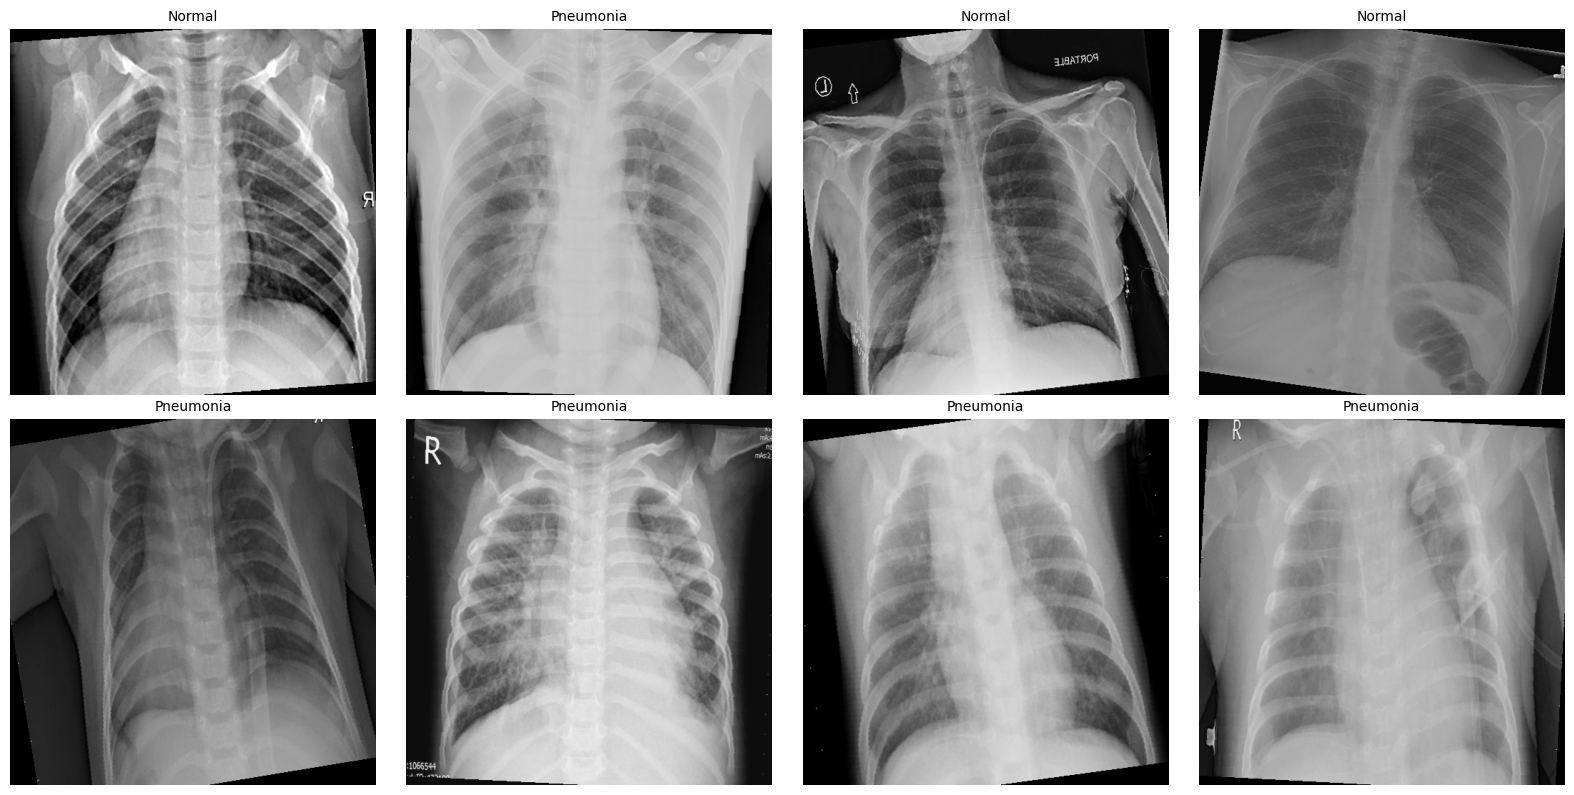

In [7]:
# Cell 7: Visualize batch
def denormalize(tensor, mean, std):
    t = tensor.clone()
    for i, (m, s) in enumerate(zip(mean, std)):
        t[i] = t[i] * s + m
    return t

def show_batch(images, labels, classes, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(n, len(images))):
        img = denormalize(images[i], mean, std)
        img = img.permute(1, 2, 0).numpy().clip(0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{classes[labels[i]]}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n🖼️  Visualizing training batch:")
show_batch(images, labels, train_dataset.classes)

In [8]:
# Cell 8: Check class distribution
from collections import Counter

def check_distribution(loader, n_batches=10):
    all_labels = []
    for i, (_, labels) in enumerate(loader):
        if i >= n_batches:
            break
        all_labels.extend(labels.tolist())
    
    counts = Counter(all_labels)
    total = len(all_labels)
    
    print(f"\nDistribution in {n_batches} batches:")
    for idx, count in sorted(counts.items()):
        cls = loader.dataset.classes[idx]
        pct = count/total*100
        print(f"  {cls:15s}: {count:4d} ({pct:5.2f}%)")

check_distribution(train_loader)


Distribution in 10 batches:
  COVID-19       :    9 ( 5.62%)
  Normal         :   66 (41.25%)
  Pneumonia      :   78 (48.75%)
  Tuberculosis   :    7 ( 4.38%)


In [9]:
# Cell 9: GPU test
if torch.cuda.is_available():
    print("\n" + "=" * 70)
    print("🔥 GPU TEST")
    print("=" * 70)
    
    device = torch.device('cuda:0')
    images_gpu = images.to(device)
    labels_gpu = labels.to(device)
    
    print(f"✅ Moved to: {images_gpu.device}")
    print(f"GPU memory: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    
    # Simple forward pass test
    import time
    dummy = torch.nn.Conv2d(3, 64, 3).to(device)
    
    start = time.time()
    _ = dummy(images_gpu)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    print(f"Forward pass: {elapsed*1000:.2f}ms")
    print(f"Throughput: {batch_size/elapsed:.1f} img/s")
else:
    print("\n⚠️  CUDA not available")


🔥 GPU TEST
✅ Moved to: cuda:0
GPU memory: 48.00 MB
Forward pass: 1694.89ms
Throughput: 9.4 img/s



🎨 Augmentation Examples:


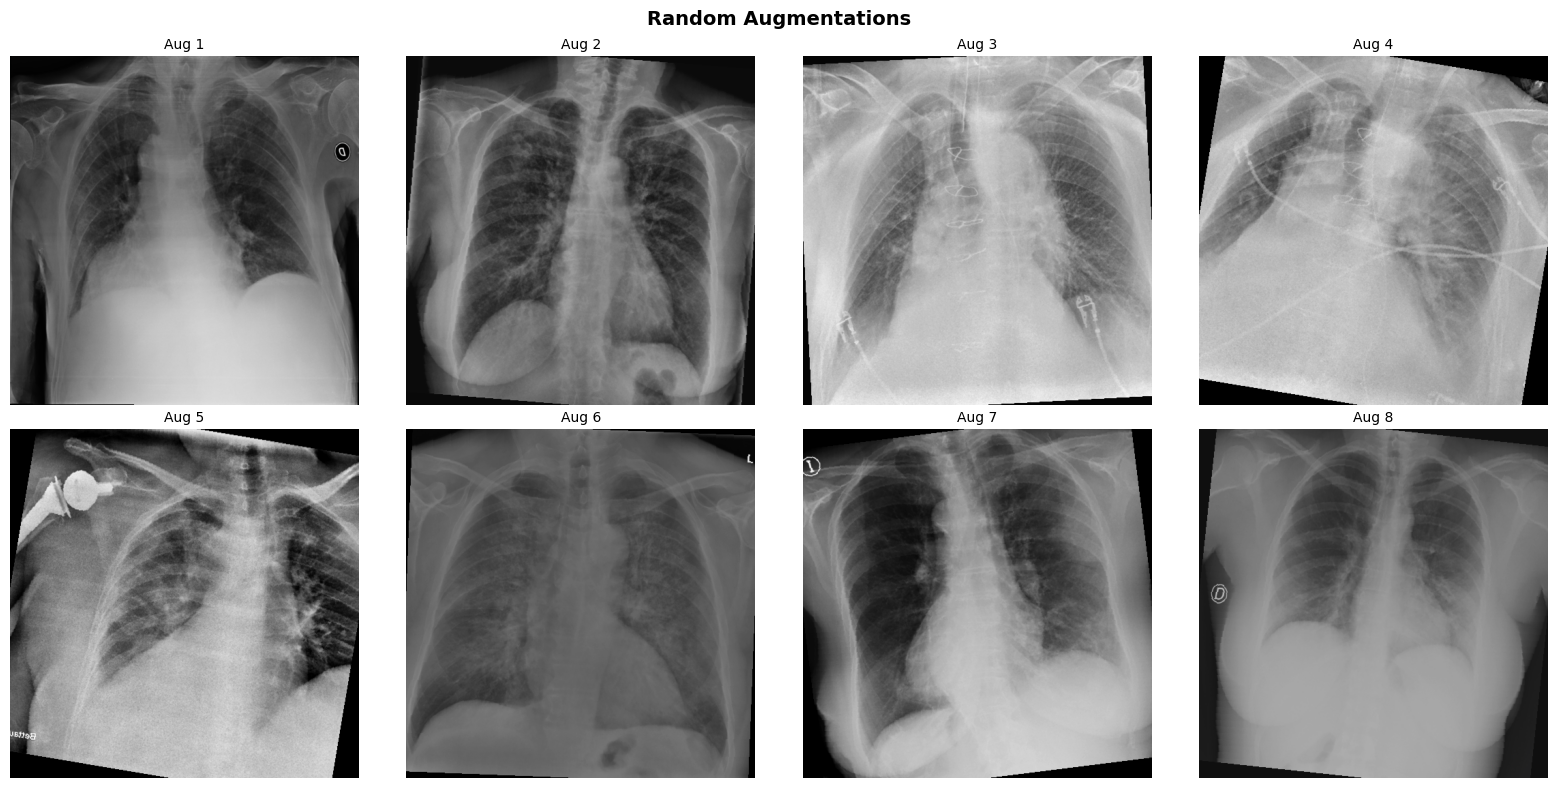

In [10]:
# Cell 10: Visualize augmentations
print("\n🎨 Augmentation Examples:")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img, _ = train_dataset[i]
    img = denormalize(img, mean, std)
    img = img.permute(1, 2, 0).numpy().clip(0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Aug {i+1}", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Random Augmentations", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Cell 11: Summary
print("\n" + "=" * 70)
print("🎉 DATALOADER TEST COMPLETE!")
print("=" * 70)

print("\n✅ Verified:")
print(f"  1. Datasets: {len(train_dataset):,} + {len(val_dataset):,} + {len(test_dataset):,}")
print(f"  2. Batch shape: {images.shape}")
print(f"  3. Normalization: mean≈{images.mean():.3f}, std≈{images.std():.3f}")
print(f"  4. Augmentation: working")
print(f"  5. GPU: {'available' if torch.cuda.is_available() else 'not available'}")

print("\n📌 Config:")
print(f"  Image size: 512x512")
print(f"  Batch size: {batch_size}")
print(f"  Mean: {mean}")
print(f"  Std:  {std}")
print(f"  Classes: {train_dataset.classes}")

print("\n🚀 READY FOR TRAINING!")
print("\nNext steps:")
print("  1. Define baseline CNN model")
print("  2. Implement training loop")
print("  3. Train & evaluate")


🎉 DATALOADER TEST COMPLETE!

✅ Verified:
  1. Datasets: 11,546 + 2,471 + 2,471
  2. Batch shape: torch.Size([16, 3, 512, 512])
  3. Normalization: mean≈0.021, std≈0.994
  4. Augmentation: working
  5. GPU: available

📌 Config:
  Image size: 512x512
  Batch size: 16
  Mean: [0.4908561706542969, 0.49303561449050903, 0.4940687119960785]
  Std:  [0.2407049834728241, 0.24082882702350616, 0.24142147600650787]
  Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']

🚀 READY FOR TRAINING!

Next steps:
  1. Define baseline CNN model
  2. Implement training loop
  3. Train & evaluate
